In [1]:
from brainrender.atlas_specific import GeneExpressionAPI
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from tqdm import tqdm
import pandas as pd

import matplotlib
font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

%matplotlib widget

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
geapi = GeneExpressionAPI()
gene_info = geapi.get_all_genes()
gene_info.head()

,id,gene_symbol,gene_name,entrez_gene_id,homologene_group_id
0,158383,1700010L04Rik,RIKEN cDNA 1700010L04 gene,619808,None
1,46574,6330411E07Rik,RIKEN cDNA 6330411E07 gene,70733,None
2,106388,6330581N18Rik,RIKEN cDNA 6330581N18 gene,319453,None
3,106517,6430573F11Rik,RIKEN cDNA 6430573F11 gene,319582,35306
4,87409,A2m,alpha-2-macroglobulin,232345,37248


In [3]:
gene = "Pcp4"
expids = geapi.get_gene_experiments(gene)
data = geapi.get_gene_data(gene=gene,  exp_id=expids[0])

In [4]:
data_dims = data.shape
xs, zs, ys = [np.arange(data_dims[i]) for i in range(3)]

coords = np.array(np.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
outcome = np.array([data[c[0], c[2], c[1]] for c in coords])
assert len(outcome) == len(coords)

observed_idx = np.where(outcome > 2)
coords = coords[observed_idx]
coords[:, 2] = np.max(coords[:, 2]) - coords[:, 2]
outcome = outcome[observed_idx]
outcome = (outcome - outcome.mean()) / outcome.std()

pd.DataFrame(coords).to_csv("./out/aba_coords.csv", index=False)
pd.DataFrame(outcome).to_csv("./out/aba_outcome.csv", index=False)


coords = coords.astype(np.float64)
coords -= coords.mean(0)
coords += np.random.uniform(low=-0.5, high=0.5, size=coords.shape)

subset_size = 2_000
subset_idx = np.random.choice(np.arange(len(coords)), size=subset_size, replace=False)
coords = coords[subset_idx]
outcome = outcome[subset_idx]

In [5]:
def compute_point_to_plane_dists(points, plane, signed=False):
#     dists_signed = np.dot(points, plane[:3]) + plane[3] / np.linalg.norm(plane[:3], ord=2)
    dists_signed = (plane[0] * points[:, 0] + plane[1] * points[:, 1] + plane[2] * points[:, 2] + plane[3]) / np.sqrt(np.sum(plane[:3] ** 2))
    return dists_signed if signed else np.abs(dists_signed)

def compute_eig(noise_var, cov):
    return 0.5 * np.linalg.slogdet(1 / noise_variance * cov + np.eye(len(cov)))[
        1
    ]

def meshgrid2(*arrs):
    arrs = tuple(reversed(arrs))  #edit
    lens = [len(x) for x in arrs] # map(len, arrs)
    dim = len(arrs)

    sz = 1
    for s in lens:
        sz*=s

    ans = []    
    for i, arr in enumerate(arrs):
        slc = [1]*dim
        slc[i] = lens[i]
        arr2 = np.asarray(arr).reshape(slc)
        for j, sz in enumerate(lens):
            if j!=i:
                arr2 = arr2.repeat(sz, axis=j) 
        ans.append(arr2)

    return tuple(ans)

In [6]:
np.random.seed(1)

In [7]:
coords.shape, outcome.shape
n_neighbors = 10

n_repeats = 10
frac_drop = 0.5

mse_full_atlas = np.zeros(n_repeats)
for ii in range(n_repeats):
    
    # Randomly drop points
    test_idx = np.random.choice(np.arange(len(coords)), size=int(frac_drop * len(coords)), replace=False)
    train_idx = np.setdiff1d(np.arange(len(coords)), test_idx)
    coords_train, outcome_train = coords[train_idx], outcome[train_idx]
    coords_test, outcome_test = coords[test_idx], outcome[test_idx]
    
    # Fit GP
    gpr = GPR(kernel=RBF(length_scale=10) + WhiteKernel(1.)) #, optimizer=None)
    gpr.fit(coords_train, outcome_train)
#     knn = KNeighborsRegressor(n_neighbors=n_neighbors)
#     knn.fit(coords_train, outcome_train)
    
    # Make predictions for dropped points
    preds = gpr.predict(coords_test)
#     preds = knn.predict(coords_test)
    
    # Compute MSE
    mse = np.mean((preds - outcome_test) ** 2)
#     mse_full_atlas[ii] = mse
    mse_full_atlas[ii] = r2_score(outcome_test, preds)
    print(mse_full_atlas[ii])
print(mse_full_atlas)

0.5632356259084239
0.6052477552680549
0.6310658726898908
0.579909907720263
0.634591350013205
0.6257185361773384
0.5988572582519864
0.5873051604692501
0.6282106694725235
0.5794304522766593
[0.56323563 0.60524776 0.63106587 0.57990991 0.63459135 0.62571854
 0.59885726 0.58730516 0.62821067 0.57943045]


## EIG (with fragmenting) and serial slicing

In [8]:
np.random.seed(1)

## Number of experimental iterations (slices)
num_experimental_iters = 15
n_repeats = 3

## Discretize design space (slices / set of planes through the tissue)
grid_size = 5
lims = [-40, 40]
# out = meshgrid2(
#     np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), grid_size),
#     np.linspace(-3, 3, grid_size),
#     [-1], #np.linspace(lims[0], lims[1], grid_size),
#     [0],
# )
out = meshgrid2(
    np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), grid_size),
    np.linspace(-3, 3, grid_size),
    np.linspace(lims[0], lims[1], grid_size),
    np.linspace(lims[0], lims[1], grid_size),
)
designs = np.stack([np.ravel(x) for x in out], axis=1)
# designs = np.stack([np.array([0, -1, yy, 0]) for yy in np.linspace(-3, 3, grid_size)], axis=0)
# designs = np.stack([np.array([0, -1, 0, yy]) for yy in np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), grid_size)], axis=0)
designs_serial = np.stack([np.array([0, -1, 0, yy]) for yy in np.linspace(np.min(coords[:, 1]), np.max(coords[:, 1]), num_experimental_iters)], axis=0)
serial_designs_idx = np.arange(len(designs_serial))
np.random.shuffle(serial_designs_idx)
CLOSE_DIST = 0.5
kernel = RBF(length_scale=10)
noise_variance = np.var(outcome)

accuracy_overall = np.zeros((n_repeats, num_experimental_iters))
accuracy_overall_serial = np.zeros((n_repeats, num_experimental_iters))

for repeat_ii in range(n_repeats):
    
    
    coords = np.array(np.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
    outcome = np.array([data[c[0], c[2], c[1]] for c in coords])
    assert len(outcome) == len(coords)

    observed_idx = np.where(outcome > 2)
    coords = coords[observed_idx]
    coords[:, 2] = np.max(coords[:, 2]) - coords[:, 2]
    outcome = outcome[observed_idx]
    outcome = (outcome - outcome.mean()) / outcome.std()


    coords = coords.astype(np.float64)
    coords -= coords.mean(0)
    coords += np.random.uniform(low=-0.5, high=0.5, size=coords.shape)

    subset_idx = np.random.choice(np.arange(len(coords)), size=subset_size, replace=False)
    coords = coords[subset_idx]
    outcome = outcome[subset_idx]
    
    

    tissue_fragments_idx = [np.arange(len(coords))]
    observed_idx = []
    observed_idx_serial = []
    chosen_designs = []
    mse_eig = np.zeros(num_experimental_iters)
    mse_serial = np.zeros(num_experimental_iters)

    for experimental_iter in range(num_experimental_iters):

        best_eig = -np.inf
        best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

        for ff in range(len(tissue_fragments_idx)):

            curr_coords = coords[tissue_fragments_idx[ff]]
            curr_outcome = outcome[tissue_fragments_idx[ff]]

            ## Loop over designs
            for dd, design in enumerate(designs):

                ## Get normal vector of plane
                normal_vector = design[:3] / np.linalg.norm(design[:3], ord=2)

                ## Find new observed points
                dists_signed = compute_point_to_plane_dists(curr_coords, design, signed=True)
                dists = np.abs(dists_signed)
                curr_observed_idx = np.where(dists < CLOSE_DIST)[0]

                if len(curr_observed_idx) == 0:
                    continue

                if experimental_iter == 0:
                    cov = kernel(curr_coords[curr_observed_idx])
                else:

                    ## Compute EIG
                    K_XX = kernel(coords[observed_idx])
                    K_XtestXtest = kernel(curr_coords[curr_observed_idx])
                    K_XXtest = kernel(coords[observed_idx], curr_coords[curr_observed_idx])
                    cov = K_XtestXtest + noise_variance * np.eye(len(K_XtestXtest)) - K_XXtest.T @ np.linalg.solve(K_XX + noise_variance * np.eye(len(K_XX)), K_XXtest)

                curr_eig = compute_eig(noise_variance, cov)

                if curr_eig > best_eig:
                    best_design_idx = dd
                    best_fragment_idx = ff
                    best_observed_idx = tissue_fragments_idx[ff][curr_observed_idx]
                    best_eig = curr_eig

                assert len(np.intersect1d(observed_idx, tissue_fragments_idx[ff][curr_observed_idx])) == 0


        curr_best_design = designs[best_design_idx]
        best_fragment_coords = coords[tissue_fragments_idx[best_fragment_idx]]

        dists_signed = compute_point_to_plane_dists(best_fragment_coords, curr_best_design, signed=True)

        above_plane_idx = np.where(dists_signed > 0)[0]
        below_plane_idx = np.where(dists_signed <= 0)[0]

        above_idx = tissue_fragments_idx[best_fragment_idx][above_plane_idx]
        below_idx = tissue_fragments_idx[best_fragment_idx][below_plane_idx]
        above_idx = np.setdiff1d(above_idx, best_observed_idx)
        below_idx = np.setdiff1d(below_idx, best_observed_idx)

        tissue_fragments_idx.pop(best_fragment_idx)
        if len(above_idx) > 0:
            tissue_fragments_idx.append(above_idx)
        if len(below_idx) > 0:
            tissue_fragments_idx.append(below_idx)

        chosen_designs.append(curr_best_design)
        observed_idx.extend(best_observed_idx)

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx)

        if len(observed_idx) > 0.5 * len(coords):
            train_idx = np.random.choice(observed_idx, size=int(0.5 * len(coords)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(coords)), train_idx)
        else:
            train_idx = observed_idx.copy()
            test_idx = unobserved_idx.copy()

        ## Fit GP, make predictions, and compute error

    #     knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    #     knn.fit(coords[observed_idx], outcome[observed_idx])
    #     preds = knn.predict(coords[unobserved_idx])
        gpr = GPR(kernel=RBF(length_scale=10) + WhiteKernel(1.)) #, optimizer=None)
        gpr.fit(coords[train_idx], outcome[train_idx])
        preds = gpr.predict(coords[test_idx])

        mse = np.mean((preds - outcome[test_idx]) ** 2)
        mse_eig[experimental_iter] = r2_score(outcome[test_idx], preds)
    #     mse_eig[experimental_iter] = mse


        ## Compare with serial slicing strategy
        ## Get normal vector of plane
        curr_naive_design = designs_serial[serial_designs_idx[experimental_iter]]
        normal_vector = curr_naive_design[:3] / np.linalg.norm(curr_naive_design[:3], ord=2)

        ## Find new observed points
        dists_signed = compute_point_to_plane_dists(coords, curr_naive_design)
        dists = np.abs(dists_signed)
        curr_observed_idx = np.where(dists < CLOSE_DIST)[0]
        observed_idx_serial.extend(curr_observed_idx)

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx_serial)

        if len(observed_idx_serial) > 0.5 * len(coords):
            train_idx = np.random.choice(observed_idx_serial, size=int(0.5 * len(coords)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(coords)), train_idx)
        else:
            train_idx = observed_idx_serial.copy()
            test_idx = unobserved_idx.copy()

        # Fit GP and make predictions

    #     knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    #     knn.fit(coords[observed_idx_serial], outcome[observed_idx_serial])
    #     preds = knn.predict(coords[unobserved_idx])
        gpr = GPR(kernel=RBF(length_scale=10) + WhiteKernel(1.)) #, optimizer=None)
        gpr.fit(coords[train_idx], outcome[train_idx])
        preds = gpr.predict(coords[test_idx])

        mse = np.mean((preds - outcome[test_idx]) ** 2)
    #     mse_serial[experimental_iter] = mse
        mse_serial[experimental_iter] = r2_score(outcome[test_idx], preds)

#         print("MSE EIG: {}, MSE serial: {}".format(round(mse_eig[experimental_iter], 2), round(mse_serial[experimental_iter], 2)))
#         print(len(observed_idx), len(observed_idx_serial))
        
    accuracy_overall[repeat_ii] = mse_eig
    accuracy_overall_serial[repeat_ii] = mse_serial



## EIG (no fragmenting)

In [9]:
np.random.seed(1)

mse_eig_no_fragmenting_overall = np.zeros((n_repeats, num_experimental_iters))

for repeat_ii in range(n_repeats):
    
    coords = np.array(np.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
    outcome = np.array([data[c[0], c[2], c[1]] for c in coords])
    assert len(outcome) == len(coords)

    observed_idx = np.where(outcome > 2)
    coords = coords[observed_idx]
    coords[:, 2] = np.max(coords[:, 2]) - coords[:, 2]
    outcome = outcome[observed_idx]
    outcome = (outcome - outcome.mean()) / outcome.std()


    coords = coords.astype(np.float64)
    coords -= coords.mean(0)
    coords += np.random.uniform(low=-0.5, high=0.5, size=coords.shape)

    subset_idx = np.random.choice(np.arange(len(coords)), size=subset_size, replace=False)
    coords = coords[subset_idx]
    outcome = outcome[subset_idx]

    observed_idx = []
    observed_idx_serial = []
    chosen_designs = []
    mse_eig_no_fragmenting = np.zeros(num_experimental_iters)

    for experimental_iter in range(num_experimental_iters):

        best_eig = -np.inf
        best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx)
        curr_coords = coords[unobserved_idx]
        curr_outcome = outcome[unobserved_idx]

        ## Loop over designs
        for dd, design in enumerate(designs):

            ## Get normal vector of plane
            normal_vector = design[:3] / np.linalg.norm(design[:3], ord=2)

            ## Find new observed points
            dists_signed = compute_point_to_plane_dists(curr_coords, design, signed=True)
            dists = np.abs(dists_signed)
            curr_observed_idx = np.where(dists < CLOSE_DIST)[0]

            if len(curr_observed_idx) == 0:
                continue
        #     projected_points = curr_coords[curr_observed_idx] - (dists_signed[curr_observed_idx] * normal_vector.reshape(-1, 1)).T

            if experimental_iter == 0:
                cov = kernel(curr_coords[curr_observed_idx])
            else:

                ## Compute EIG
                K_XX = kernel(coords[observed_idx])
                K_XtestXtest = kernel(curr_coords[curr_observed_idx])
                K_XXtest = kernel(coords[observed_idx], curr_coords[curr_observed_idx])
                cov = K_XtestXtest + noise_variance * np.eye(len(K_XtestXtest)) - K_XXtest.T @ np.linalg.solve(K_XX + noise_variance * np.eye(len(K_XX)), K_XXtest)
    #             

            curr_eig = compute_eig(noise_variance, cov)

            if curr_eig > best_eig:
                best_design_idx = dd
                best_fragment_idx = ff
                best_observed_idx = unobserved_idx[curr_observed_idx]
                best_eig = curr_eig



        curr_best_design = designs[best_design_idx]
    #     best_fragment_coords = coords[tissue_fragments_idx[best_fragment_idx]]



        chosen_designs.append(curr_best_design)
        observed_idx.extend(best_observed_idx)

        unobserved_idx = np.setdiff1d(np.arange(len(coords)), observed_idx)

        if len(observed_idx) > 0.5 * len(coords):
            train_idx = np.random.choice(observed_idx, size=int(0.5 * len(coords)), replace=False)
            test_idx = np.setdiff1d(np.arange(len(coords)), train_idx)
        else:
            train_idx = observed_idx.copy()
            test_idx = unobserved_idx.copy()


        ## Fit GP, make predictions, and compute error

    #     knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    #     knn.fit(coords[observed_idx_serial], outcome[observed_idx_serial])
    #     preds = knn.predict(coords[unobserved_idx])
        gpr = GPR(kernel=RBF(length_scale=10) + WhiteKernel(1.)) #, optimizer=None)
        gpr.fit(coords[train_idx], outcome[train_idx])
        preds = gpr.predict(coords[test_idx])

        mse = np.mean((preds - outcome[test_idx]) ** 2)
        mse_eig_no_fragmenting[experimental_iter] = r2_score(outcome[test_idx], preds)
    #     mse_eig_no_fragmenting[experimental_iter] = mse



#         print("MSE EIG: {}".format(round(mse_eig_no_fragmenting[experimental_iter], 2)))
#         print(len(observed_idx))
        
    mse_eig_no_fragmenting_overall[repeat_ii] = mse_eig_no_fragmenting



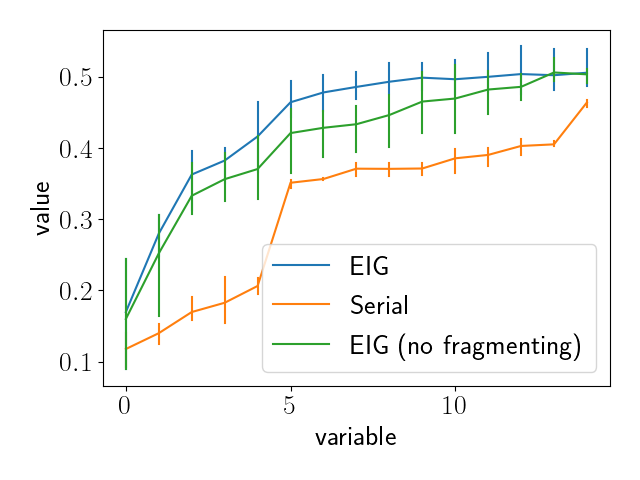

In [10]:
plt.close()
sns.lineplot(data=pd.melt(pd.DataFrame(accuracy_overall)), x="variable", y="value", err_style="bars", label="EIG")
sns.lineplot(data=pd.melt(pd.DataFrame(accuracy_overall_serial)), x="variable", y="value", err_style="bars", label="Serial")
sns.lineplot(data=pd.melt(pd.DataFrame(mse_eig_no_fragmenting_overall)), x="variable", y="value", err_style="bars", label="EIG (no fragmenting)")
plt.tight_layout()
plt.show()

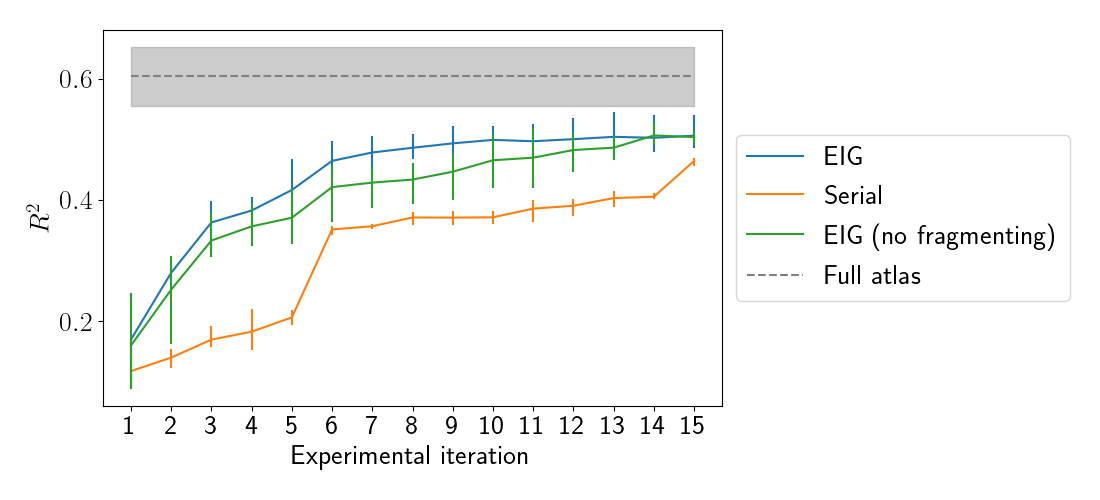

In [13]:
plt.close()
plt.figure(figsize=(11, 5))
# plt.plot(np.arange(num_experimental_iters), mse_serial, label="Serial")
# plt.plot(np.arange(num_experimental_iters), mse_eig, label="EIG")
# plt.plot(np.arange(num_experimental_iters), mse_eig_no_fragmenting, label="EIG (no fragmenting)")

sns.lineplot(data=pd.melt(pd.DataFrame(accuracy_overall)), x="variable", y="value", err_style="bars", label="EIG")
sns.lineplot(data=pd.melt(pd.DataFrame(accuracy_overall_serial)), x="variable", y="value", err_style="bars", label="Serial")
sns.lineplot(data=pd.melt(pd.DataFrame(mse_eig_no_fragmenting_overall)), x="variable", y="value", err_style="bars", label="EIG (no fragmenting)")

plt.xticks(np.arange(num_experimental_iters), labels=np.arange(1, num_experimental_iters + 1))

# plt.axhline(np.mean(mse_full_atlas), color="gray", linestyle="--", label="Full atlas", x)
plt.plot([0, num_experimental_iters - 1], 
         [np.mean(mse_full_atlas), np.mean(mse_full_atlas)], 
         color="gray", 
         linestyle="--", 
         label="Full atlas")
plt.fill_between(np.arange(num_experimental_iters), 
                 np.mean(mse_full_atlas) - 2 * np.std(mse_full_atlas), 
                 np.mean(mse_full_atlas) + 2 * np.std(mse_full_atlas), 
                 color="gray", 
                 alpha=0.4)

plt.xlabel("Experimental iteration")
plt.ylabel(r"$R^2$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("./out/mse_aba_design_experiment.png")
plt.show()

In [12]:
# plt.close()
# fig = plt.figure(figsize=(5, 5))
# ax = plt.axes(projection='3d')

# ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], c=outcome, alpha=0.3)

# # ax.set_xlabel("x")
# ax.set_ylabel("Anterior <--> Posterior", rotation=90)
# ax.set_zlabel("Inferior <--> Superior", rotation=90)


# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# zlim = ax.get_zlim()

# plt.close()
# # plt.show()


# plt.close()
# fig = plt.figure(figsize=(5, 5))
# ax = plt.axes(projection='3d')

# for P in chosen_designs:
#     dists = np.abs(P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.sqrt(np.sum(P[:3] ** 2))

#     close_idx = np.where(dists < CLOSE_DIST)


#     normal_vector = P[:3] / np.linalg.norm(P[:3], ord=2)
#     dists_signed = (P[0] * coords[:, 0] + P[1] * coords[:, 1] + P[2] * coords[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
#     projected_points = coords[close_idx] - (dists_signed[close_idx] * normal_vector.reshape(-1, 1)).T

#     projected_point_dists = np.abs(P[0] * projected_points[:, 0] + P[1] * projected_points[:, 1] + P[2] * projected_points[:, 2] + P[3]) / np.linalg.norm(P[:3], ord=2)
#     assert np.allclose(projected_point_dists, 0)

#     ax.scatter3D(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], c=outcome[close_idx])
# #     ax.scatter3D(coords[close_idx][:, 0], coords[close_idx][:, 1], coords[close_idx][:, 2], c=outcome[close_idx])



# ax.set_ylabel("Anterior -- Posterior", rotation=90)
# ax.set_zlabel("Inferior -- Superior", rotation=90)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_zlim(zlim)

# plt.tight_layout()
# # plt.savefig("./out/aba_example_resulting_slice.png")

# plt.show()